Convolutional neural networks 

This work is based on the MNIST dataset, in which each image is indexed by a number between 0 and 9.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

Create data loaders for training, validation and test sets.

In [2]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

Documentation of Data loaders: https://pytorch.org/docs/stable/data.html

In [3]:
#Let's define how many samples per batch to load
batch_size = 20
#Percentage of training set to use as a validation set
valid_size = 0.2

def create_data_loaders(batch_size, valid_size, train_data, test_data):
    indices = list(range(len(train_data)))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size*len(train_data)))
    train_index, valid_index = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    return train_loader, valid_loader, test_loader


In [4]:
train_loader, valid_loader, test_loader = create_data_loaders(20, 0.2, train_data, test_data)

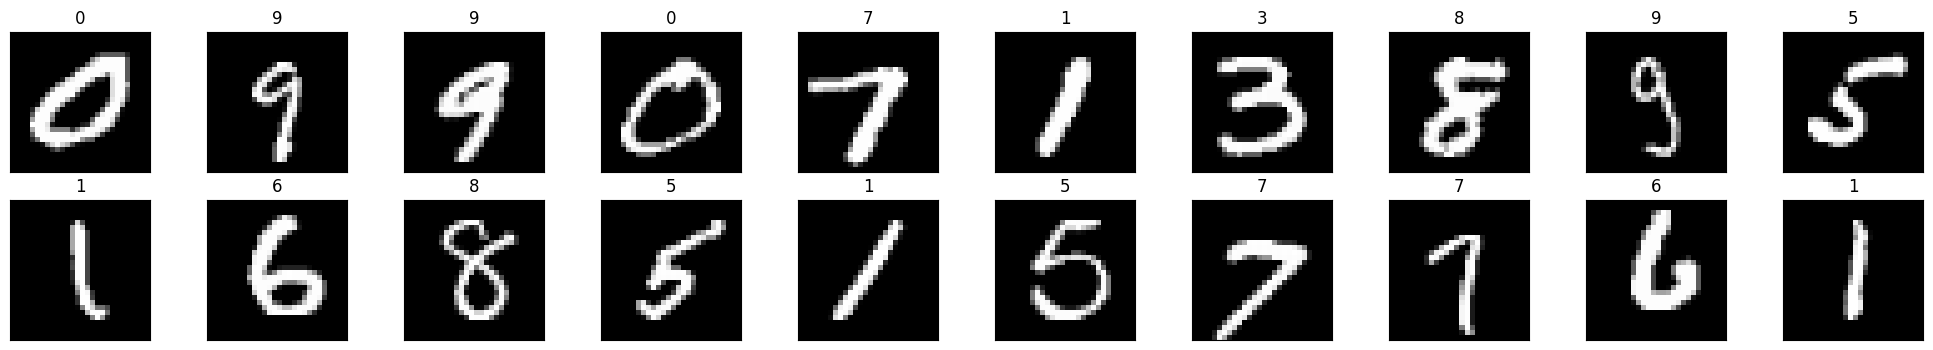

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))


References: 

-nn.Conv2D: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

-max-pooling layer using nn.MaxPool2D: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

-nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html



In [6]:
import torch.nn as nn 
import torch.nn.functional as F

class Net1(nn.Module):

    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Conv2d(1, 32, kernel_size = (3,3), stride= 1)
        self.fc2 = nn.Conv2d(32, 32, kernel_size = (3,3), stride = 1)
        self.fc3 = nn.MaxPool2d((2, 2))
        self.fc4 = nn.Linear(32 * 12 * 12, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = x.view(-1,32*12*12)
        out = self.fc4(x)
        return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [9]:
from torchsummary import summary

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

summary(cnn_1, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Linear-4                   [-1, 10]          46,090
Total params: 55,658
Trainable params: 55,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.21
Estimated Total Size (MB): 0.56
----------------------------------------------------------------


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01)

In [11]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss

      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
            output = model(data)
            loss = criterion(output, label)
          valid_loss += loss.item() * data.size(0)

      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [12]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.718688 	validation Loss: 0.367176
validation loss decreased (inf --> 0.367176).  Saving model ...
epoch: 2 	training Loss: 0.369126 	validation Loss: 0.340938
validation loss decreased (0.367176 --> 0.340938).  Saving model ...
epoch: 3 	training Loss: 0.317643 	validation Loss: 0.330140
validation loss decreased (0.340938 --> 0.330140).  Saving model ...
epoch: 4 	training Loss: 0.270352 	validation Loss: 0.260710
validation loss decreased (0.330140 --> 0.260710).  Saving model ...
epoch: 5 	training Loss: 0.217646 	validation Loss: 0.215650
validation loss decreased (0.260710 --> 0.215650).  Saving model ...
epoch: 6 	training Loss: 0.175635 	validation Loss: 0.186025
validation loss decreased (0.215650 --> 0.186025).  Saving model ...
epoch: 7 	training Loss: 0.141960 	validation Loss: 0.157219
validation loss decreased (0.186025 --> 0.157219).  Saving model ...
epoch: 8 	training Loss: 0.118092 	validation Loss: 0.162093
epoch: 9 	training Loss: 0.102595 

Text(0, 0.5, 'loss value')

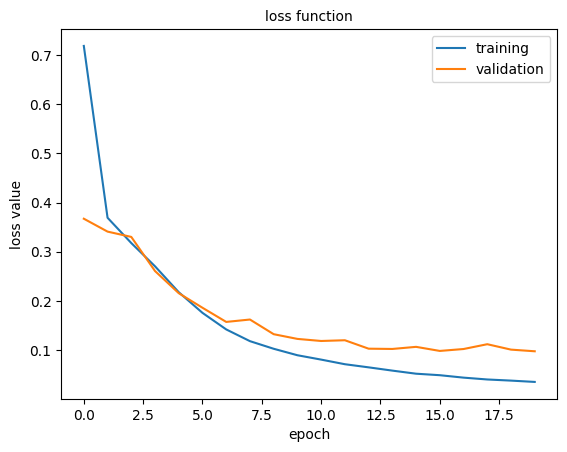

In [14]:
#Convergence?
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['training', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)